In [31]:
beginDate = '2015-7-7'
endDate = '2020-7-5'
inipct = 0.05  #每个行业选股数量占比
Factor = 'private.Hacken_Dividend_Org'
iniasc = 0 #因子升序或降序

reblance_freq = 20  # 调仓间隔期（交易日）

In [2]:
a= get_factor(order_book_ids=['000001.XSHE'], 
                        start_date=beginDate, 
                        end_date=endDate, 
                        factor=Factor)
a

2014-01-02   -3.067275
2014-01-03   -3.059027
2014-01-06   -3.009067
2014-01-07   -3.020981
2014-01-08   -3.003145
2014-01-09   -2.985497
2014-01-10   -2.955542
2014-01-13   -2.975020
2014-01-14   -2.976221
2014-01-15   -3.012076
2014-01-16   -3.031473
2014-01-17   -3.017640
2014-01-20   -3.023037
2014-01-21   -3.027748
2014-01-22   -3.059974
2014-01-23   -3.095988
2014-01-24   -3.110929
2014-01-27   -3.095469
2014-01-28   -3.058246
2014-01-29   -3.023589
2014-01-30   -3.038557
2014-02-07   -3.066203
2014-02-10   -3.085785
2014-02-11   -3.048603
2014-02-12   -3.047199
2014-02-13   -2.991760
2014-02-14   -3.027261
2014-02-17   -3.071537
2014-02-18   -3.095987
2014-02-19   -3.001409
                ...   
2020-05-21   -1.914974
2020-05-22   -1.895526
2020-05-25   -1.910365
2020-05-26   -1.904047
2020-05-27   -1.952545
2020-05-28   -0.935543
2020-05-29   -0.911591
2020-06-01   -0.914865
2020-06-02   -0.942451
2020-06-03   -0.927965
2020-06-04   -0.943665
2020-06-05   -0.953704
2020-06-08 

In [3]:
import rqalpha
import rqalpha_plus
import rqdatac

In [4]:
import pandas as pd
import numpy as np
import scipy.stats as st
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
#plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False  

In [5]:
def del_st(univ, date):
    """
    剔除ST的股票
    输入：
        univ：list，股票池
        date：str，日期
    返回：
        remove_st_univ：list，处理后的股票池
    """
    st_list = []
    for stk in univ:
        st = rqdatac.is_st_stock(stk, start_date=date, end_date=date)
        st_list.append(st)
        
    st_df = pd.concat(st_list, axis=1)
    remove_st_univ = st_df[st_df == False].columns
    return remove_st_univ


def del_suspended(univ, date):
    """
    剔除停牌，未上市，退市的股票
    输入：
        univ：list，股票池
        date：str，日期
    返回：
        remove_susp_univ：list，处理后的股票池
    """
    suspended_list = []
    for stk in univ:
        suspended = rqdatac.is_suspended(stk, start_date=date, end_date=date)
        suspended_list.append(suspended)
        
    suspended_df = pd.concat(suspended_list, axis=1)    
    remove_susp_univ = suspended_df[suspended_df == False].columns
    return remove_susp_univ


def del_new(univ, date, day = 60):
    """
    剔除某个日期前多少个交易日,之后上市的新股
    输入：
        univ：list，股票池
        date：str，日期
        day：floor，新股的天数
    返回：
        remove_new_univ：list，处理后的股票池
    """
    remove_new_univ = []
    for stk in univ:
        listDate = rqdatac.instruments(stk).days_from_listed(date)
        
        if listDate > day:
            remove_new_univ.append(stk)
    return remove_new_univ

In [6]:
def get_A_private_factor(tradeDate_list, private_factor):
    """
    获取全部A股的内部因子
    输入：
        tradeDate_list：list，交易日
        private_factor：str，因子名称
    返回：
        DataFrame：index为tradeDate，secID，columns为factor
    """
    print ('get private_factor:')

    univ = rqdatac.all_instruments(type='CS')['order_book_id'].tolist()

    factor = get_factor(order_book_ids=univ, 
                        start_date=trade_date_list[0], 
                        end_date=trade_date_list[-1], 
                        factor=private_factor)
    print(factor)
    factor = factor.stack().to_frame('factor')
    factor.index.names = ['tradeDate', 'secID']
    return factor

In [7]:
def get_industry(tradeDate_list, source_='sws'):
    """
    获取全部股票的行业
    输入：
        tradeDate_list：list，交易日
        source_：（sws 申万, citics 中信, gildata 聚源）
    返回：
        DataFrame：index为tradeDate，secID，columns为‘industry’
    """
    print ('get industry:')
    count = 0
    secs_time = 0
    start_time = time.time()
    N = 20
    
    ind_df = pd.DataFrame()
    for date in tradeDate_list:
        univ = rqdatac.all_instruments(type='CS',date=date)['order_book_id'].tolist()
        univ = del_suspended(univ, date)
        univ = del_st(univ, date)
        univ = del_new(univ, date, day = 60)

        univ_ind = rqdatac.get_instrument_industry(univ, source=source_, date=date)
        univ_ind.reset_index(inplace=True)
        univ_ind['tradeDate'] = date
        ind_df = ind_df.append(univ_ind)
        
        count += 1
        if count > 0 and count % N == 0:
            finish_time = time.time()
            print (count,)
            print ('  ' + str(np.round((finish_time-start_time) - secs_time, 0)) + ' seconds elapsed.')
            secs_time = (finish_time-start_time)

    ind_df = ind_df[['tradeDate','order_book_id', 'first_industry_name']]
    ind_df.columns = ['tradeDate', 'secID', 'industry']
    ind_df.set_index(['tradeDate','secID'], inplace=True)
    return ind_df

**交易日列表**

In [8]:
trade_date_list = get_trading_dates(start_date=beginDate, end_date=endDate)
trade_date_list = [date.strftime('%Y-%m-%d') for date in trade_date_list]

**获取数据**

In [9]:
factor = get_A_private_factor(trade_date_list, Factor)
factor.to_csv('Hacken_Quality_Org.csv')

get private_factor:
            000553.XSHE  601718.XSHG  002938.XSHE  300733.XSHE  000584.XSHE  \
2014-01-02    -0.761514    -0.728751          NaN          NaN    -0.243215   
2014-01-03    -0.758286    -0.723326          NaN          NaN    -0.247429   
2014-01-06    -0.752724    -0.740396          NaN          NaN          NaN   
2014-01-07    -0.741490    -0.742639          NaN          NaN    -0.271586   
2014-01-08    -0.736430    -0.722276          NaN          NaN    -0.272705   
2014-01-09    -0.743696    -0.724489          NaN          NaN    -0.272902   
2014-01-10    -0.754295    -0.733954          NaN          NaN    -0.288993   
2014-01-13    -0.748626    -0.728842          NaN          NaN    -0.293231   
2014-01-14    -0.746629    -0.680789          NaN          NaN    -0.280219   
2014-01-15    -0.750250    -0.669837          NaN          NaN    -0.268919   
2014-01-16    -0.739116    -0.660897          NaN          NaN    -0.268392   
2014-01-17    -0.730925    -0.64

**更新行业数据**

In [10]:
IND = pd.read_csv('industry.csv')
beginDate_IND = IND['tradeDate'].unique()[0]

updata_list = get_trading_dates(start_date=beginDate, end_date=beginDate_IND)
updata_list = [date.strftime('%Y-%m-%d') for date in updata_list]

if len(updata_list) > 1:
    IND_updata = get_industry(updata_list, source_='sws')
    IND_updata = IND_updata.reset_index()
    IND = pd.concat([IND_updata, IND], axis=0)
    IND = IND.reset_index(drop=True)
    IND.to_csv('industry.csv', index=False) 

In [11]:
IND = pd.read_csv('industry.csv')
lastDate_IND = IND['tradeDate'].unique()[-1]

updata_list = get_trading_dates(start_date=lastDate_IND, end_date=endDate)
updata_list = [date.strftime('%Y-%m-%d') for date in updata_list]

if len(updata_list) > 1:
    IND_updata = get_industry(updata_list, source_='sws')
    IND_updata = IND_updata.reset_index()
    IND = pd.concat([IND, IND_updata], axis=0)
    IND = IND.reset_index(drop=True)
    IND.to_csv('industry.csv', index=False) 
    
IND.iloc[[0,-1],:]

,tradeDate,secID,industry
0,2013-12-03,000001.XSHE,金融服务
5043398,2020-07-03,688399.XSHG,医药生物


**因子使用处理后的股票池**

In [12]:
factor = pd.read_csv('Hacken_Quality_Org.csv')
factor = pd.merge(factor, IND, 
                  left_on=['tradeDate','secID'], right_on=['tradeDate','secID'], how='right')

factor = factor[['tradeDate','secID', 'factor']]
factor.iloc[[0,-1],:]

,tradeDate,secID,factor
0,2014-01-02,000553.XSHE,-0.761514
5043398,2020-07-03,688399.XSHG,NaN


**根据基准构建投资组合**

In [13]:
def portfolio_weight(factor_df, ind_df, benchmark='000905.XSHG', 
                     benchmark_inside=True, pct=0.1, lower_num=2, asc=0):
    """
    根据基准构建投资组合
    输入：
        factor_df：因子数据，DataFrame，columns为：['secID', 'tradeDate', 'facotr']
        ind_df：行业数据，DataFrame，columns为：['secID', 'tradeDate', 'industry']
        benchmark：基准代码
        benchmark_inside：True为基准内选股，False为指定股票池选股
        pct：benchmark_inside = True，基准内选股时，为 投资组合的股票数目 相对 基准 的比例
                                     指定股票池选股时，为 投资组合的股票数目 相对 指定股票池 的比例
        lower_num：每个行业最少选股数目
        asc：因子排序，0降序，1升序
    返回：
        DataFrame，columns为：[tradeDate,secID,industry,ind_weight,target_num,target_weight]
    """

    all_data = pd.DataFrame()
    factor_df = pd.merge(factor_df, ind_df, on=['tradeDate', 'secID'], how='left')
    # 交易日list
    tradeDate_list = sorted(factor_df['tradeDate'].unique())
    for tradeDate in tradeDate_list:
        
        # 当期的数据
        temp_factor = factor_df[factor_df['tradeDate'] == tradeDate]
        temp_factor.reset_index(drop=True ,inplace=True)
        
        # 指数内的股票在当前指数的权重
        industry_weights = rqdatac.index_weights(benchmark, date=tradeDate
                                                ).to_frame('stock_weight').reset_index()
        industry_weights.rename(columns={'order_book_id':'secID'}, inplace=True)

        industry_weights = pd.merge(industry_weights, temp_factor[['secID', 'industry']], 
                                    on=['secID'], how='left')

        if benchmark_inside == True:
            # 只保留指数内的股票
            temp_factor = pd.merge(industry_weights[['secID']], temp_factor, 
                                    on=['secID'], how='inner')

        # 根据行业求指数分布权重
        benchmark_industry_weight = industry_weights.groupby("industry").sum()
        # 归一化
        benchmark_industry_weight /= benchmark_industry_weight.sum()
        # 指数的行业权重
        benchmark_industry_weight.rename(columns={'stock_weight':'ind_weight'}, inplace=True)
        benchmark_industry_weight.reset_index(inplace=True)
        
        # 行业内的股票数目
        ind_weight_num = temp_factor.groupby(by='industry'
                                            ).apply(lambda x: len(x)).to_frame('num').reset_index()
        # 合并 行业权重 和 行业内的股票数目
        benchmark_industry_weight = pd.merge(benchmark_industry_weight, ind_weight_num, 
                                             on=['industry'], how='left')
        # 行业内选股数目
        benchmark_industry_weight['target_num'] = benchmark_industry_weight['num'] * pct
        benchmark_industry_weight['target_num'] = benchmark_industry_weight['target_num'
                                                        ].apply(lambda x: int(x))
        benchmark_industry_weight['target_num'] = benchmark_industry_weight['target_num'
                                                        ].apply(lambda x: x if x >=lower_num else lower_num)
        # 行业内选股的个股权重
        benchmark_industry_weight['target_weight'] = benchmark_industry_weight['ind_weight'
                                                ] / benchmark_industry_weight['target_num']
        # 合并因子和行业数据
        temp_data = pd.merge(temp_factor, 
                    benchmark_industry_weight[['industry', 'target_num', 'ind_weight', 'target_weight']], 
                    on=['industry'], how='right')
        # 因子排序
        temp_data.sort_values(by='factor', ascending=asc, inplace=True)

        temp_data_ = temp_data.groupby(by='industry'
                                      ).apply(lambda x: x.iloc[:x['target_num'].unique()[0]])
        
        temp_data_.set_index(['tradeDate','secID'], inplace=True)
        temp_data_ = temp_data_[['industry', 'ind_weight', 'target_num', 'target_weight']]
        
        all_data = all_data.append(temp_data_)   
    all_data = all_data.reset_index()
    return all_data

In [14]:
def append_mkt(all_data):
    """
    加入总市值数据
    输入：
        DataFrame，columns为：[tradeDate,secID...]
    返回：
        DataFrame，columns为：[tradeDate,secID...,LFLO]
    """
    lflo = rqdatac.get_factor(order_book_ids=all_data['secID'].unique(), 
                              factor='market_cap',
                              start_date=all_data['tradeDate'].unique()[0],
                              end_date=all_data['tradeDate'].unique()[-1])
    
    lflo.index = [dt.strftime('%Y-%m-%d') for dt in lflo.index]
    lflo = lflo.unstack().to_frame().reset_index()
    lflo.columns =['secID', 'tradeDate', 'LFLO']

    all_data = pd.merge(all_data, lflo, 
                        left_on=['tradeDate', 'secID'], right_on=['tradeDate', 'secID'], how='inner')
    return all_data

In [15]:
def portfolio_mkt_weight(all_data, limit_pct=0.04):
    """
    对输入的组合，行业内的使用总市值加权
    输入：
        DataFrame，columns为：[tradeDate,secID,industry,ind_weight,target_num,
                              target_weight,LFLO]
        limit_pct：float，单支股票最大权重
    返回：
        DataFrame，index为：['tradeDate', 'secID']，columns为：[LFLO_target_weight]
    """
    all_df = pd.DataFrame()
    # 交易日list
    tradeDate_list = sorted(all_data['tradeDate'].unique())
    for tradeDate in tradeDate_list:

        # 当期的数据
        temp_data = all_data[all_data['tradeDate'] == tradeDate]
        temp_data.reset_index(drop=True ,inplace=True)

        temp_df = pd.DataFrame()
        # 行业名称
        ind_list = temp_data['industry'].unique()
        for ind_name in ind_list:

            # 当期的行业内数据
            temp_ind_data = temp_data[temp_data['industry'] == ind_name].copy()
            temp_ind_data.reset_index(drop=True ,inplace=True)
            
            temp_ind_data['LFLO_target_weight'] = temp_ind_data['LFLO'
                                                        ] * temp_ind_data['target_weight']

            # 归一化
            temp_ind_data['LFLO_target_weight'] /= temp_ind_data['LFLO_target_weight'].sum() 
            temp_ind_data['LFLO_target_weight'] *= temp_ind_data['ind_weight']

            # 单支股票权重不超过 pct
            temp_ind_data['LFLO_target_weight'] = temp_ind_data['LFLO_target_weight'
                                                ].apply(lambda x: x if x <=limit_pct else limit_pct)
            
            # 单独处理低于阈值的股票
            temp_ind_data['LFLO_target_weight_min'] = temp_ind_data['LFLO_target_weight'
                                ].apply(lambda x: x if x <limit_pct else np.nan)
            
            # 对低于阈值的股票归一化
            temp_ind_data['LFLO_target_weight_min'] /= temp_ind_data[
                                                        'LFLO_target_weight_min'].sum()
            temp_ind_data['LFLO_target_weight_min'] *= temp_ind_data['ind_weight']
            
            # 更新低于阈值的股票的权重
            temp_ind_data['LFLO_target_weight'] = [temp_ind_data.LFLO_target_weight_min[i] 
                                    if temp_ind_data.LFLO_target_weight_min[i] != np.nan
                                    else temp_ind_data.LFLO_target_weight[i] 
                                    for i in range(len(temp_ind_data))]
            
            # 再次归一化
            temp_ind_data['LFLO_target_weight'] /= temp_ind_data['LFLO_target_weight'].sum() 
            temp_ind_data['LFLO_target_weight'] *= temp_ind_data['ind_weight']

            # 单支股票权重不超过 pct
            temp_ind_data['LFLO_target_weight'] = temp_ind_data['LFLO_target_weight'
                                                ].apply(lambda x: x if x <=limit_pct else limit_pct)
            
            # 再次归一化
            temp_ind_data['LFLO_target_weight'] /= temp_ind_data['LFLO_target_weight'].sum() 
            temp_ind_data['LFLO_target_weight'] *= temp_ind_data['ind_weight']

            
            temp_ind_data = temp_ind_data[['tradeDate', 'secID', 'LFLO_target_weight']]
            temp_df = temp_df.append(temp_ind_data)

        all_df = all_df.append(temp_df)
    all_df = all_df.set_index(['tradeDate', 'secID'])    
    return all_df

In [16]:
all_data = portfolio_weight(factor, IND, benchmark='000905.XSHG', 
                            benchmark_inside=False, pct=inipct, lower_num=2, asc=iniasc)

all_data = append_mkt(all_data)

portfolio_weight = portfolio_mkt_weight(all_data, limit_pct=0.05)
portfolio_weight.fillna(0, inplace=True)

portfolio_weight.head()

LFLO_target_weight
tradeDate  secID                          
2013-12-03 000017.XSHE            0.001537
           000025.XSHE            0.001136
           000030.XSHE            0.005246
           000338.XSHE            0.027660
           000550.XSHE            0.013436

**回测**

In [32]:
config = {
    "base": {
        "matching_type": "current_bar",
        "start_date": beginDate, 
        "end_date": endDate,
        "frequency": '1d',
        "accounts": {"stock": 1e9},
        "benchmark": "000905.XSHG",
            },
    
    "mod": {"sys_analyser": {"enabled": True, "plot": True}},
    
    "extra": {"log_level": 'error'} 
}


In [33]:
def filter_limit_up(bar_dict, stock):
    return bar_dict[stock].last < bar_dict[stock].limit_up*0.999


def filter_limit_down(bar_dict, stock):
    return bar_dict[stock].limit_down*1.001 < bar_dict[stock].last



def rebalance(context, bar_dict):
    pre_tradeDate = rqalpha.api.get_previous_trading_date(context.now, n=1).strftime('%Y-%m-%d')
    
    tradeDate_list = portfolio_weight.index.get_level_values(0).unique().tolist()[::reblance_freq]
    if pre_tradeDate not in tradeDate_list:
        return
    else:
        signal_df = portfolio_weight.loc[pre_tradeDate, :].dropna()
        filter_stock_list = []
        for stock in signal_df.index:
            if filter_limit_up(bar_dict, stock) and not rqalpha.api.is_suspended(stock, 1):
                filter_stock_list.append(stock)

        signal_df = signal_df.loc[filter_stock_list]
        signal_df['LFLO_target_weight'] = signal_df['LFLO_target_weight'
                                                   ] / np.sum(signal_df['LFLO_target_weight']) * 0.99
        
        signal_dict = dict(signal_df.squeeze())
        context.stocks = signal_df.index.tolist()
        rqalpha.api.update_universe(context.stocks)
    
        for stock in context.portfolio.positions.keys():
            if stock not in context.stocks:
                if filter_limit_down(bar_dict, stock) and not rqalpha.api.is_suspended(stock, 1):
                    rqalpha.api.order_target_percent(stock, 0)

        capital = context.stock_account.total_value * (1 - context.cash_cushion)
        positions = context.portfolio.positions
        
        to_sell, to_buy = {}, {}
        for stock, weight in signal_dict.items():
            target_value = capital * weight
            delta_value = target_value - positions[stock].market_value
            
            if isinstance(delta_value, float):
                if delta_value > 30000:
                    to_buy[stock] = delta_value
                else:
                    to_sell[stock] = delta_value
                
        for stock, value in to_sell.items():
            if filter_limit_down(bar_dict, stock) and not rqalpha.api.is_suspended(stock, 1):
                rqalpha.api.order_value(stock, value)
            
        for stock, value in to_buy.items():
            if filter_limit_up(bar_dict, stock) and not rqalpha.api.is_suspended(stock, 1):
                valuec=value
                if valuec >context.portfolio.cash*0.99:
                    valuec =context.portfolio.cash*0.99
                rqalpha.api.order_value(stock, valuec)
        
        #rqalpha.api.order_value('600201.XSHG', context.portfolio.cash*0.99)
                
                
def init(context):
    context.cash_cushion = 0.02
    rqalpha.api.scheduler.run_daily(rebalance)
   

def handle_bar(context, bar_dict):
    pass


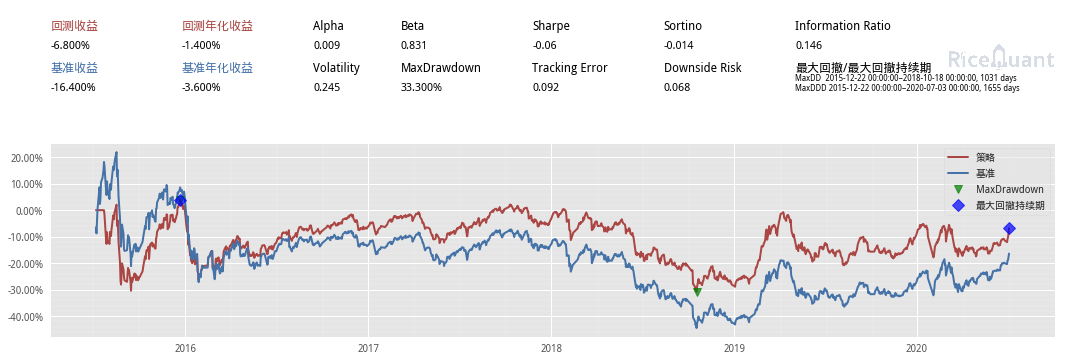

2020-07-03 INFO 策略耗时:  63.040093660354614


In [34]:
start_time = time.time()
res = rqalpha_plus.run_func(init=init, handle_bar=handle_bar, config=config)
finish_time = time.time()
secs_time = (finish_time-start_time)
print ('策略耗时: ',secs_time)

In [35]:
def cumulative_excess_return(backtest_result):
    strat_portf = backtest_result['sys_analyser']['portfolio']
    benchmark_portf = backtest_result['sys_analyser']['benchmark_portfolio']
    
    strat_return = strat_portf['total_value'].pct_change()
    benchmark_return = benchmark_portf['total_value'].pct_change()
    
    excess_return = strat_return - benchmark_return
    
    return ( excess_return).cumsum()+1
    

def average_turnover(backtest_result):
    sell_trades = backtest_result['sys_analyser']['trades'].query("side == 'SELL'")
    portfolio = backtest_result['sys_analyser']['portfolio']
    
    total_trade_value = lambda df: (df['last_price'] * df['last_quantity']).sum()
    value_sold = sell_trades.groupby(sell_trades.index, group_keys=False).apply(total_trade_value)
    value_sold.index = pd.to_datetime(value_sold.index).date
    
    capital = portfolio.loc[value_sold.index, 'total_value']
    
    return (value_sold / capital).mean()

In [36]:
cum_excess_return = cumulative_excess_return(res)
turnover = average_turnover(res)

2020-07-03 INFO Average Turnover: 0.2270821494874598


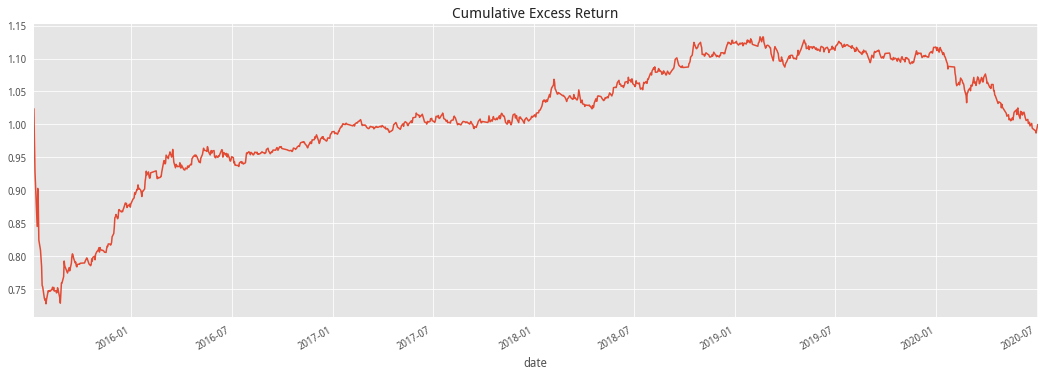

In [37]:
%matplotlib inline
cum_excess_return.plot(title='Cumulative Excess Return', figsize=(18, 6))
print('Average Turnover: %s' % turnover)

In [23]:
excess_df = cum_excess_return.to_frame('excess')
excess_df.to_csv('excess_test.csv')

nav_df = res['sys_analyser']['portfolio'][['unit_net_value']].copy()
nav_df.rename(columns={'unit_net_value':'net_value'}, inplace=True)
nav_df.to_csv('net_value_test.csv')

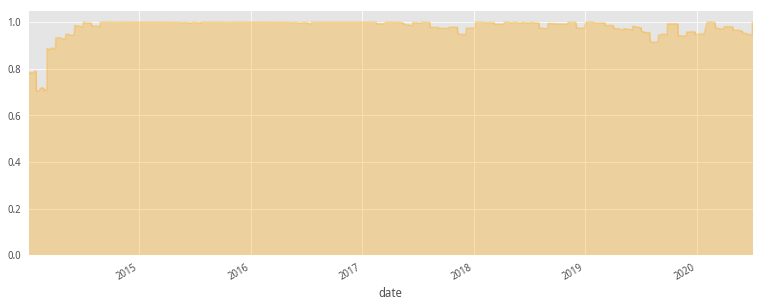

In [24]:
stock_account_ = res['sys_analyser']['stock_account'].copy()
stock_account_['market_value_pct'] = stock_account_['market_value'] / stock_account_['total_value']
stock_account_['market_value_pct'].plot(kind='area', color='orange', alpha=0.3, figsize=(13,5))

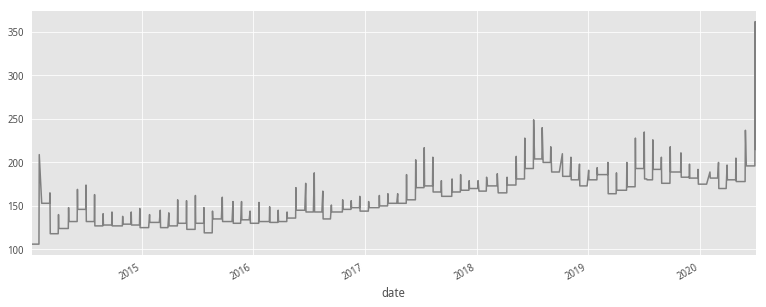

In [25]:
res['sys_analyser']['stock_positions'].groupby(level='date').size().plot(color='grey', figsize=(13,5))

In [26]:
trades = res['sys_analyser']['trades']
trades_case = trades[['order_book_id', 'side', 'last_quantity', 'last_price', 'transaction_cost']]
trades_case.index = [dt[:10] for dt in trades_case.index]
trades_case.index.name = 'datetime'
trades_case.to_csv('trades_case_test.csv')
trades_case.head(3)

,order_book_id,side,last_quantity,last_price,transaction_cost
datetime,,,,,
2014-01-02,000025.XSHE,BUY,152300.0,8.80,1072.1920
2014-01-02,000030.XSHE,BUY,891200.0,6.14,4377.5744
2014-01-02,000338.XSHE,BUY,1045100.0,18.74,15668.1392


In [27]:
strategy_nav_df = res['sys_analyser']['portfolio'][['unit_net_value']].copy()
strategy_nav_df.rename(columns={'unit_net_value':'strategy'}, inplace=True)

benchmark_nav_df = res['sys_analyser']['benchmark_portfolio'][['unit_net_value']].copy()
benchmark_nav_df.rename(columns={'unit_net_value':'benchmark'}, inplace=True)

nav_df_ = pd.concat([strategy_nav_df, benchmark_nav_df], axis=1)
cpt_df = nav_df_.copy()
cpt_df = cpt_df.pct_change()

In [28]:
def annual_ret_plot(cpt_df):
    """
    策略和基准的年度收益对比
    输入：
        cpt_df：DataFrame，index为日期，columns为'strategy'，'benchmark'
    """
    frame_ret = cpt_df.copy()
    frame_ret.index = frame_ret.index.map(lambda x: x[:4])
    frame_ret = frame_ret.applymap(lambda x: x+1)
    frame_ret['year'] = frame_ret.index
    frame_ret = frame_ret.groupby(by='year').agg('cumprod')
    frame_ret['year'] = frame_ret.index

    frame_ret.drop_duplicates(subset='year', keep='last', inplace=True)
    frame_ret.set_index('year', inplace=True)
    frame_ret = frame_ret.applymap(lambda x: x-1)

    frame_ret_ = frame_ret.applymap(lambda x: np.round(x*100, 0))
    frame_ret_.columns.name = '年化收益'
    frame_ret_['收益差额'] = frame_ret_['strategy'] - frame_ret_['benchmark']
    frame_ret_ = frame_ret_.applymap(lambda x: str(x)+'%')

    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    frame_ret.columns.name = 'name'
    ax = frame_ret.plot(kind='bar', ax=ax, alpha=0.8)
    ax.set_ylabel(u'return(%)', fontsize=10)
    ax.grid(True)
    return frame_ret_

In [29]:
cpt_a_df = cpt_df.copy()
cpt_a_df.dropna(how='all', inplace=True)
cpt_a_df.index = [date.strftime('%Y-%m-%d') for date in cpt_a_df.index]

frame_ret = cpt_a_df.copy()
frame_ret.index = frame_ret.index.map(lambda x: x[:7])
frame_ret = frame_ret.applymap(lambda x: x+1)
frame_ret['year_month'] = frame_ret.index
frame_ret = frame_ret.groupby(by='year_month').agg('cumprod')
frame_ret['year_month'] = frame_ret.index

frame_ret.drop_duplicates(subset='year_month', keep='last', inplace=True)
frame_ret.set_index('year_month', inplace=True)
frame_ret = frame_ret.applymap(lambda x: x-1)
frame_ret = frame_ret.dropna()
frame_ret['hedging'] = frame_ret['strategy'] - frame_ret['benchmark']

win_prob = 100.0 * len(frame_ret[frame_ret['hedging'] >= 0]
                                                    )  / len(frame_ret)

win_prob_se = pd.Series({'月度胜率（%）':win_prob}).to_frame('hedging')
win_prob_se

,hedging
月度胜率（%）,58.227848


年化收益,strategy,benchmark,收益差额
year,,,
2014,45.0%,38.0%,7.0%
2015,65.0%,43.0%,22.0%
2016,-8.0%,-18.0%,10.0%
2017,3.0%,-0.0%,3.0%
2018,-25.0%,-33.0%,8.0%
2019,27.0%,26.0%,1.0%
2020,3.0%,15.0%,-12.0%


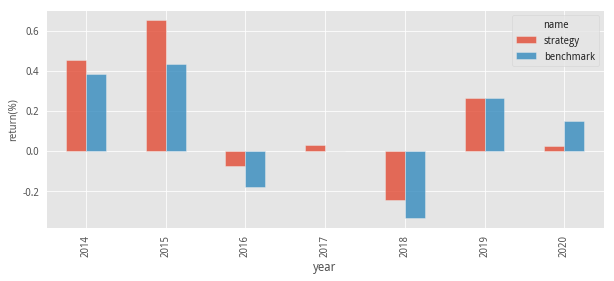

In [30]:
annual_ret_plot(cpt_a_df)